In [97]:
import torch   

from torchtext.legacy import data   
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [98]:
TEXT = data.Field(tokenize='spacy',batch_first=True,include_lengths=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)

/opt/conda/lib/python3.8/site-packages/torchtext/data/utils.py:123: UserWarning:

Spacy model "en" could not be loaded, trying "en_core_web_sm" instead



In [99]:
fields = [(None, None), ('text',TEXT),('label', LABEL)]

In [100]:
training_data=data.TabularDataset(path = 'Balanced.csv',format = 'csv',fields = fields,skip_header = True)
print(vars(training_data.examples[0]))

{'text': ['(:', 'best', '.', 'the', 'just', 'seriously', 'It', "'s", 'are', '.', 'friends', 'true', 'your', 'who', 'out', 'finding', 'love', 'I'], 'label': '0'}


In [101]:
import random
train_data, valid_data = training_data.split(split_ratio=0.9, random_state = random.seed(SEED))

In [102]:
TEXT.build_vocab(train_data,min_freq=3,vectors = "glove.6B.100d")  
LABEL.build_vocab(train_data)

print("Size of TEXT vocabulary:",len(TEXT.vocab))

print("Size of LABEL vocabulary:",len(LABEL.vocab))

print(TEXT.vocab.freqs.most_common(10))  

print(TEXT.vocab.stoi)  

Size of TEXT vocabulary: 804
Size of LABEL vocabulary: 2
[('love', 886), ('i', 875), ('#', 676), ('being', 503), ('to', 400), ('USER', 359), ('.', 353), ('the', 351), ('?', 289), ('!', 278)]
defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7f3389a92820>>, {'<unk>': 0, '<pad>': 1, 'love': 2, 'i': 3, '#': 4, 'being': 5, 'to': 6, 'USER': 7, '.': 8, 'the': 9, '?': 10, '!': 11, 'I': 12, 'just': 13, 'my': 14, 'a': 15, ',': 16, 'you': 17, 'in': 18, 'getting': 19, 'of': 20, 'and': 21, 'for': 22, 'it': 23, "'s": 24, "n't": 25, 'ignored': 26, 'is': 27, 'do': 28, 'at': 29, 'me': 30, 'on': 31, '..': 32, 'that': 33, 'URL': 34, 'by': 35, 'with': 36, 'up': 37, 'all': 38, 'out': 39, 'not': 40, '{': 41, '}': 42, 'number': 43, 'like': 44, 'be': 45, 'so': 46, 'this': 47, 'have': 48, 'sick': 49, 'how': 50, '"': 51, 'no': 52, 'when': 53, "'m": 54, 'are': 55, 'your': 56, 'day': 57, 'oh': 58, 'was': 59, 'know': 60, 'people': 61, '-': 62, 'much': 63, 'what': 64, 'got': 

In [103]:
device = torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')  

BATCH_SIZE = 64

train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_data, valid_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

In [104]:
import torch.nn as nn

class classifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout):
        
        super().__init__()          
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
    
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
    
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
      
        self.act = nn.Sigmoid()
        
    def forward(self, text, text_lengths):
      
        embedded = self.embedding(text)
    
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(),batch_first=True)
        
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
      
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
     
        dense_outputs=self.fc(hidden)

        outputs=self.act(dense_outputs)
        
        return outputs

In [105]:
size_of_vocab = len(TEXT.vocab)
embedding_dim = 100
num_hidden_nodes = 32
num_output_nodes = 1
num_layers = 2
bidirection = True
dropout = 0.2

model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes,num_output_nodes, num_layers, 
                   bidirectional = True, dropout = dropout)

In [106]:
print(model)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

print(pretrained_embeddings.shape)

classifier(
  (embedding): Embedding(804, 100)
  (lstm): LSTM(100, 32, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (act): Sigmoid()
)
The model has 139,857 trainable parameters
torch.Size([804, 100])


In [107]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

def binary_accuracy(preds, y):
    rounded_preds = torch.round(preds)
    
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
model = model.to(device)
criterion = criterion.to(device)

In [108]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()  
    
    for batch in iterator:
        
        optimizer.zero_grad()   
        
        text, text_lengths = batch.text   
        
        predictions = model(text, text_lengths).squeeze()  

        loss = criterion(predictions, batch.label)        
      
        acc = binary_accuracy(predictions, batch.label)   
       
        loss.backward()       
     
        optimizer.step()      
       
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [109]:
predictions1 = []
ground_label = []

In [110]:
def evaluate(model, iterator, criterion):
    
    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    #deactivating dropout layers
    model.eval()
    
    #deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            #retrieve text and no. of words
            text, text_lengths = batch.text
            
            #convert to 1d tensor
            predictions = model(text, text_lengths).squeeze()
            
            #compute loss and accuracy
            for i in range(0, len(batch.label)):
                predictions1.append(predictions[i].cpu().detach().numpy())
                ground_label.append(batch.label[i].cpu().detach().numpy())
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            
            #keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [111]:
N_EPOCHS = 50
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
  
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
   
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

	Train Loss: 0.645 | Train Acc: 71.65%
	 Val. Loss: 0.536 |  Val. Acc: 86.30%
	Train Loss: 0.326 | Train Acc: 95.91%
	 Val. Loss: 0.170 |  Val. Acc: 94.07%
	Train Loss: 0.087 | Train Acc: 97.90%
	 Val. Loss: 0.093 |  Val. Acc: 97.68%
	Train Loss: 0.039 | Train Acc: 99.28%
	 Val. Loss: 0.042 |  Val. Acc: 98.32%
	Train Loss: 0.024 | Train Acc: 99.46%
	 Val. Loss: 0.059 |  Val. Acc: 98.32%
	Train Loss: 0.013 | Train Acc: 99.88%
	 Val. Loss: 0.048 |  Val. Acc: 98.84%
	Train Loss: 0.009 | Train Acc: 99.94%
	 Val. Loss: 0.036 |  Val. Acc: 99.36%
	Train Loss: 0.006 | Train Acc: 99.94%
	 Val. Loss: 0.014 |  Val. Acc: 99.36%
	Train Loss: 0.004 | Train Acc: 99.94%
	 Val. Loss: 0.023 |  Val. Acc: 99.36%
	Train Loss: 0.003 | Train Acc: 100.00%
	 Val. Loss: 0.008 |  Val. Acc: 100.00%
	Train Loss: 0.003 | Train Acc: 100.00%
	 Val. Loss: 0.007 |  Val. Acc: 100.00%
	Train Loss: 0.002 | Train Acc: 100.00%
	 Val. Loss: 0.033 |  Val. Acc: 99.36%
	Train Loss: 0.002 | Train Acc: 100.00%
	 Val. Loss: 0.007 

In [112]:
len(predictions1), len(ground_label)

(9000, 9000)

In [113]:
type(predictions1), type(ground_label)

(list, list)

In [114]:
for i in range(0, len(predictions1)):
    if predictions1[i] >= 0.99:
        predictions1[i] = 1
    else:
        predictions1[i] = 0

In [115]:
predictions1

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [116]:
ground_label

[array(1., dtype=float32),
 array(1., dtype=float32),
 array(0., dtype=float32),
 array(1., dtype=float32),
 array(1., dtype=float32),
 array(0., dtype=float32),
 array(1., dtype=float32),
 array(0., dtype=float32),
 array(0., dtype=float32),
 array(1., dtype=float32),
 array(0., dtype=float32),
 array(0., dtype=float32),
 array(1., dtype=float32),
 array(1., dtype=float32),
 array(1., dtype=float32),
 array(0., dtype=float32),
 array(0., dtype=float32),
 array(1., dtype=float32),
 array(1., dtype=float32),
 array(0., dtype=float32),
 array(0., dtype=float32),
 array(0., dtype=float32),
 array(1., dtype=float32),
 array(1., dtype=float32),
 array(1., dtype=float32),
 array(1., dtype=float32),
 array(1., dtype=float32),
 array(1., dtype=float32),
 array(1., dtype=float32),
 array(1., dtype=float32),
 array(1., dtype=float32),
 array(1., dtype=float32),
 array(1., dtype=float32),
 array(1., dtype=float32),
 array(1., dtype=float32),
 array(1., dtype=float32),
 array(1., dtype=float32),
 

In [117]:
print(classification_report(ground_label, predictions1))

              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94      3950
         1.0       1.00      0.91      0.95      5050

    accuracy                           0.95      9000
   macro avg       0.95      0.95      0.95      9000
weighted avg       0.95      0.95      0.95      9000



In [118]:
predictions1 = np.array(predictions1)
ground_label = np.array(ground_label)

# Confusion Matrix

In [119]:
fig = px.density_heatmap(x=ground_label, y=predictions1, labels={'x': 'groundtruth','y': 'prediction'})
fig.add_shape(
              type='line', line=dict(dash='dash'),
            x0 = predictions1.min(), y0 = predictions1.min(),
            x1 = predictions1.max(), y1 = predictions1.max()
)
fig.show()

# Contour Plot

In [120]:
fig = px.density_contour(x=ground_label, y=predictions1, labels={'x': 'groundtruth','y': 'prediction'})
fig.add_shape(
              type='line', line=dict(dash='dash'),
            x0 = predictions1.min(), y0 = predictions1.min(),
            x1 = predictions1.max(), y1 = predictions1.max()
)
fig.show()

# Violin Plot

In [121]:
fig = px.violin(x=ground_label, y=predictions1, labels={'x': 'groundtruth','y': 'prediction'})
fig.add_shape(
              type='line', line=dict(dash='dash'),
            x0 = predictions1.min(), y0 = predictions1.min(),
            x1 = predictions1.max(), y1 = predictions1.max()
)
fig.show()

In [122]:
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(ground_label, predictions1)
roc_auc = auc(fpr, tpr)

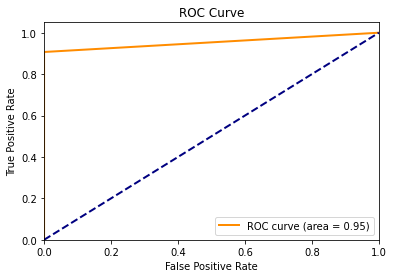

In [123]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()